<a href="https://colab.research.google.com/github/o0SilentStorm0o/VQE-in-GAN/blob/main/MNIST_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

📝 Trénink Klasifikátoru pro MNIST Dataset


---


Autor: David Strnadel

Datum: 24.4.2025

Účel: Tento sešit slouží k natrénování konvoluční neuronové sítě (CNN) pro
klasifikaci obrázků z datasetu MNIST. Výsledkem je uložený model (.pth soubor),
který lze stáhnout a použít pro další účely.

1. ⚙️ Nastavení Prostředí

V této sekci importujeme všechny potřebné knihovny a nastavíme základní parametry, jako je výpočetní zařízení (GPU/CPU).

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import os
import time # Pro měření doby tréninku

# Colab specifické importy pro stahování
from google.colab import files

# Kontrola dostupnosti GPU a nastavení zařízení
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("GPU je dostupné, používám CUDA.")
    print(f"Název GPU: {torch.cuda.get_device_name(0)}")
else:
    DEVICE = torch.device("cpu")
    print("GPU není dostupné, používám CPU.")

torch.manual_seed(42)
if DEVICE == torch.device("cuda"):
     torch.cuda.manual_seed_all(42)

GPU je dostupné, používám CUDA.
Název GPU: Tesla T4


2. 🔧 Konfigurace Tréninku

Zde definujeme všechny důležité hyperparametry a cesty pro ukládání dat a modelu. Jejich centralizace usnadňuje experimentování a úpravy.

In [2]:
# --- Hyperparametry ---
LEARNING_RATE = 0.001
BATCH_SIZE = 128
EPOCHS = 10 # Počet tréninkových epoch

# --- Cesty ---
DATA_PATH = "./MNIST_data"
CLASSIFIER_SAVE_PATH = "mnist_classifier.pth"

print("Konfigurace:")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Epochs: {EPOCHS}")
print(f"  Data Path: {DATA_PATH}")
print(f"  Model Save Path: {CLASSIFIER_SAVE_PATH}")
print(f"  Device: {DEVICE}")

Konfigurace:
  Learning Rate: 0.001
  Batch Size: 128
  Epochs: 10
  Data Path: ./MNIST_data
  Model Save Path: mnist_classifier.pth
  Device: cuda


3. 💾 Příprava Dat (MNIST)

Načteme dataset MNIST pomocí torchvision.datasets. Definujeme transformace (normalizace) a vytvoříme DataLoadery pro tréninkovou a testovací sadu.

Definované transformace:
 Compose(
    ToTensor()
    Normalize(mean=(0.5,), std=(0.5,))
)

Načítání MNIST datasetu z/do './MNIST_data'...


100%|██████████| 9.91M/9.91M [00:11<00:00, 894kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 132kB/s]
100%|██████████| 1.65M/1.65M [00:06<00:00, 244kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.0MB/s]

MNIST dataset úspěšně načten/stažen.
Vytvořen train_loader s 469 batchi (velikost 128).
Vytvořen test_loader s 79 batchi (velikost 128).

Ukázka několika obrázků z trénovací sady:


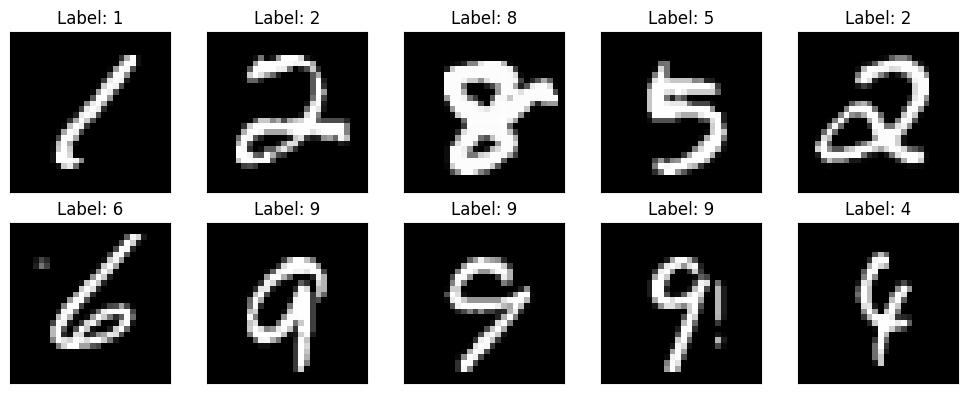

In [3]:
# --- Datové transformace ---
# Normalizace na rozsah [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
print("Definované transformace:\n", transform)

# --- Načtení datasetu ---
print(f"\nNačítání MNIST datasetu z/do '{DATA_PATH}'...")
try:
    train_dataset = datasets.MNIST(root=DATA_PATH, train=True, transform=transform, download=True)
    test_dataset = datasets.MNIST(root=DATA_PATH, train=False, transform=transform, download=True)
    print("MNIST dataset úspěšně načten/stažen.")
except Exception as e:
    print(f"Chyba při načítání/stahování datasetu: {e}")

# --- Vytvoření DataLoaderů ---
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
print(f"Vytvořen train_loader s {len(train_loader)} batchi (velikost {BATCH_SIZE}).")
print(f"Vytvořen test_loader s {len(test_loader)} batchi (velikost {BATCH_SIZE}).")


# --- Vizualizace několika vzorků ---
print("\nUkázka několika obrázků z trénovací sady:")
dataiter = iter(train_loader)
images, labels = next(dataiter)

fig = plt.figure(figsize=(10, 4))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
    img = images[idx] / 2 + 0.5
    img = img.numpy().squeeze()
    plt.imshow(img, cmap='gray')
    ax.set_title(f"Label: {labels[idx].item()}")
plt.tight_layout()
plt.show()

4. 🧠 Definice Modelu (CNN Klasifikátor)

Definujeme architekturu konvoluční neuronové sítě pro klasifikaci MNIST obrázků. Jedná se o jednoduchou, ale efektivní síť pro tento úkol.

In [4]:
class MnistClassifier(nn.Module):
    """Jednoduchá CNN pro klasifikaci MNIST."""
    def __init__(self, num_classes=10):
        super(MnistClassifier, self).__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.flatten_size = 64 * 7 * 7

        self.fc_block = nn.Sequential(
            nn.Linear(self.flatten_size, 1024),
            nn.ReLU(),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = x.view(x.size(0), -1)
        logits = self.fc_block(x)
        return logits

# --- Inicializace modelu a přesun na správné zařízení ---
classifier = MnistClassifier(num_classes=10).to(DEVICE)
print("Architektura modelu:")
print(classifier)

# Volitelně: Zobrazit přehled modelu s počtem parametrů (vyžaduje `pip install torchsummary`)
try:
    from torchsummary import summary
    summary(classifier, input_size=(1, 28, 28))
except ImportError:
    print("\nKnihovna torchsummary není nainstalována. Pro detailní přehled modelu ji nainstalujte (`pip install torchsummary`).")

Architektura modelu:
MnistClassifier(
  (conv_block1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_block): Sequential(
    (0): Linear(in_features=3136, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=10, bias=True)
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             832
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]     

5. 🚀 Trénink Modelu

V této části definujeme loss funkci, optimizer a spustíme samotný tréninkový cyklus přes definovaný počet epoch. Budeme sledovat průběh loss funkce.


Loss funkce: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

--- Zahajuji trénink ---
	Epoch: 1/10 | Batch: 100/469 | Avg Batch Loss: 0.1692
	Epoch: 1/10 | Batch: 200/469 | Avg Batch Loss: 0.2728
	Epoch: 1/10 | Batch: 300/469 | Avg Batch Loss: 0.0844
	Epoch: 1/10 | Batch: 400/469 | Avg Batch Loss: 0.0558
Epoch 1/10 dokončena | Průměrná tréninková Loss: 0.1688 | Doba trvání: 18.71s
	Epoch: 2/10 | Batch: 100/469 | Avg Batch Loss: 0.0518
	Epoch: 2/10 | Batch: 200/469 | Avg Batch Loss: 0.0113
	Epoch: 2/10 | Batch: 300/469 | Avg Batch Loss: 0.0033
	Epoch: 2/10 | Batch: 400/469 | Avg Batch Loss: 0.0473
Epoch 2/10 dokončena | Průměrná tréninková Loss: 0.0429 | Doba trvání: 14.19s
	Epoch: 3/10 | Batch: 100/469 | Avg Batch Loss: 0.0149
	Epoch: 3/10 | Batch: 200/469 | Avg Batch Loss: 0.0216
	Ep

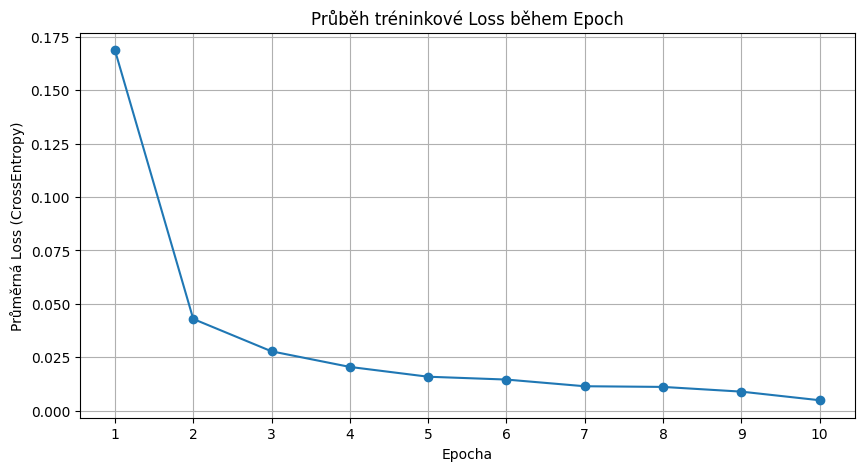

In [5]:
# --- Loss funkce a Optimizer ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=LEARNING_RATE)

print(f"\nLoss funkce: {criterion}")
print(f"Optimizer: {optimizer}")

# --- Tréninkový cyklus ---
print("\n--- Zahajuji trénink ---")
start_time = time.time()
train_losses = []

classifier.train()

for epoch in range(EPOCHS):
    epoch_start_time = time.time()
    running_loss = 0.0
    processed_samples = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)

        optimizer.zero_grad()

        outputs = classifier(data)
        loss = criterion(outputs, target)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * data.size(0)
        processed_samples += data.size(0)

        if (batch_idx + 1) % 100 == 0:
            print(f"\tEpoch: {epoch+1}/{EPOCHS} | Batch: {batch_idx+1}/{len(train_loader)} | "
                  f"Avg Batch Loss: {loss.item():.4f}")

    # Výpočet průměrné loss za epochu
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time

    print(f"Epoch {epoch+1}/{EPOCHS} dokončena | Průměrná tréninková Loss: {epoch_loss:.4f} | "
          f"Doba trvání: {epoch_duration:.2f}s")

end_time = time.time()
total_training_time = end_time - start_time
print(f"--- Trénink dokončen ---")
print(f"Celková doba tréninku: {total_training_time:.2f} sekund ({total_training_time/60:.2f} minut)")

# --- Vizualizace tréninkové loss ---
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), train_losses, marker='o', linestyle='-')
plt.title("Průběh tréninkové Loss během Epoch")
plt.xlabel("Epocha")
plt.ylabel("Průměrná Loss (CrossEntropy)")
plt.xticks(range(1, EPOCHS + 1))
plt.grid(True)
plt.show()

6. 📊 Evaluace Modelu

Po natrénování model vyhodnotíme na testovací sadě, abychom zjistili jeho přesnost (accuracy) na neviděných datech.


--- Zahajuji evaluaci na testovací sadě ---

Výsledky na testovací sadě:
  Průměrná Loss: 0.0330
  Přesnost: 9910/10000 (99.10%)

Ukázka několika predikcí na testovací sadě:


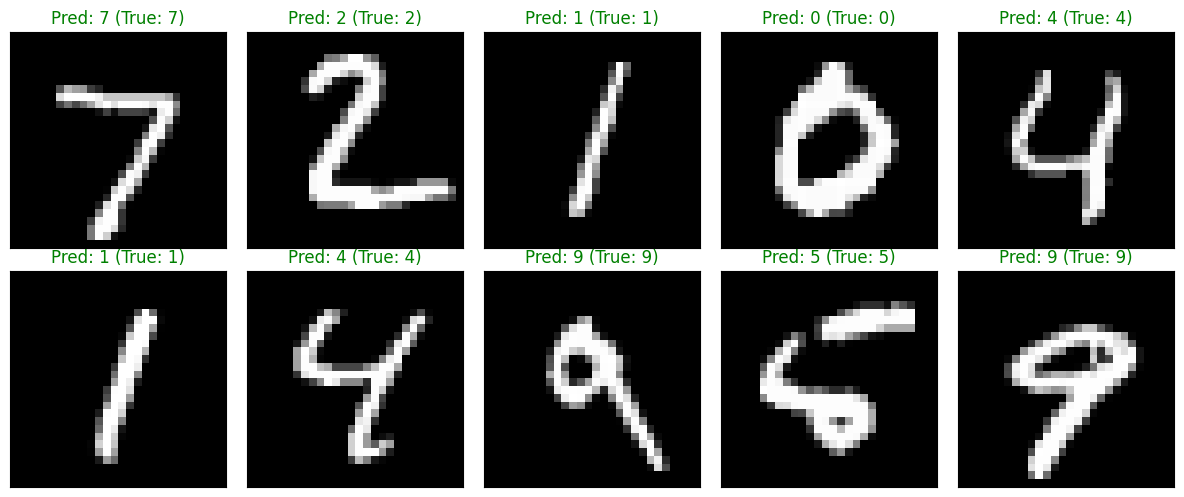

In [6]:
print("\n--- Zahajuji evaluaci na testovací sadě ---")
classifier.eval()

test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(DEVICE), target.to(DEVICE)
        outputs = classifier(data)
        loss = criterion(outputs, target)

        test_loss += loss.item() * data.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

# Výpočet průměrné loss a celkové přesnosti
avg_test_loss = test_loss / len(test_loader.dataset)
accuracy = 100. * correct / total

print(f"\nVýsledky na testovací sadě:")
print(f"  Průměrná Loss: {avg_test_loss:.4f}")
print(f"  Přesnost: {correct}/{total} ({accuracy:.2f}%)")


print("\nUkázka několika predikcí na testovací sadě:")
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(DEVICE), labels.to(DEVICE)

with torch.no_grad():
    outputs = classifier(images)
    _, predicted = torch.max(outputs, 1)

images_np = images.cpu().numpy()

fig = plt.figure(figsize=(12, 5))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
    img = images_np[idx] / 2 + 0.5
    img = img.squeeze()
    plt.imshow(img, cmap='gray')
    ax.set_title(f"Pred: {predicted[idx].item()} (True: {labels[idx].item()})",
                 color=("green" if predicted[idx]==labels[idx] else "red"))
plt.tight_layout()
plt.show()

7. 💾 Uložení a Stažení Modelu

Natrénovaný model (jeho váhy - state_dict) uložíme do souboru a nabídneme jeho stažení z prostředí Colabu.

In [7]:
# --- Uložení stavového slovníku modelu ---
torch.save(classifier.state_dict(), CLASSIFIER_SAVE_PATH)
print(f"\nModel (state_dict) úspěšně uložen do souboru: '{CLASSIFIER_SAVE_PATH}'")

# --- Stažení souboru z Colabu ---
print(f"Spouštím stahování souboru '{CLASSIFIER_SAVE_PATH}'...")
try:
    files.download(CLASSIFIER_SAVE_PATH)
    print("Stahování bylo zahájeno. Soubor by se měl objevit ve vašem prohlížeči.")
except Exception as e:
    print(f"Chyba při pokusu o stažení souboru: {e}")
    print("Soubor můžete stáhnout ručně z levého panelu 'Files' v Colabu.")


Model (state_dict) úspěšně uložen do souboru: 'mnist_classifier.pth'
Spouštím stahování souboru 'mnist_classifier.pth'...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Stahování bylo zahájeno. Soubor by se měl objevit ve vašem prohlížeči.


8. ✅ Načtení a Ověření Modelu

Tato sekce demonstruje, jak načíst uložený state_dict do nové instance modelu a ověřit, že funguje (např. opětovnou evaluací). To je užitečné pro kontrolu, že proces uložení a načtení proběhl správně.

In [8]:
print("\n--- Ověření načtení modelu ---")

# 1. Vytvořit novou instanci stejné architektury
loaded_classifier = MnistClassifier(num_classes=10).to(DEVICE)
print("Nová instance modelu vytvořena.")

# 2. Načíst uložený state_dict
try:
    loaded_classifier.load_state_dict(torch.load(CLASSIFIER_SAVE_PATH, map_location=DEVICE))
    print(f"State_dict úspěšně načten z '{CLASSIFIER_SAVE_PATH}'.")

    # 3. Přepnout do evaluačního módu
    loaded_classifier.eval()

    # 4. Znovu provést evaluaci s načteným modelem
    print("Provádím re-evaluaci s načteným modelem...")
    re_test_loss = 0.0
    re_correct = 0
    re_total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            outputs = loaded_classifier(data)
            loss = criterion(outputs, target)
            re_test_loss += loss.item() * data.size(0)
            _, predicted = torch.max(outputs.data, 1)
            re_total += target.size(0)
            re_correct += (predicted == target).sum().item()

    re_avg_test_loss = re_test_loss / len(test_loader.dataset)
    re_accuracy = 100. * re_correct / re_total
    print(f"  Re-evaluace - Průměrná Loss: {re_avg_test_loss:.4f}")
    print(f"  Re-evaluace - Přesnost: {re_correct}/{re_total} ({re_accuracy:.2f}%)")

    # Porovnání výsledků (v ideálním případě by měly být prakticky identické)
    if abs(avg_test_loss - re_avg_test_loss) < 1e-5 and abs(accuracy - re_accuracy) < 1e-2:
        print("Výsledky re-evaluace odpovídají původní evaluaci. Model byl načten správně.")
    else:
        print("Varování: Výsledky re-evaluace se liší od původní evaluace!")

except FileNotFoundError:
    print(f"Chyba: Soubor '{CLASSIFIER_SAVE_PATH}' nebyl nalezen pro načtení.")
except Exception as e:
    print(f"Nastala chyba při načítání nebo ověřování modelu: {e}")


--- Ověření načtení modelu ---
Nová instance modelu vytvořena.
State_dict úspěšně načten z 'mnist_classifier.pth'.
Provádím re-evaluaci s načteným modelem...
  Re-evaluace - Průměrná Loss: 0.0330
  Re-evaluace - Přesnost: 9910/10000 (99.10%)
Výsledky re-evaluace odpovídají původní evaluaci. Model byl načten správně.


9.🏁 Závěr

Tento sešit úspěšně natrénoval CNN klasifikátor pro MNIST dataset.